# Skimlit Project

**Project Description:** Replicating the deep learning model behind 2017 paper [_PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts_](https://arxiv.org/abs/1710.06071).

The purpose of the project is to build the NLP model to make reading medical abstract easier.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# using default seaborn theme
sns.set_theme()

## Get Data

Since we will be replicating the paper above, first we have to download the dataset.

The data is from the author's Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# check what files are in Pubmed_20K dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [4]:
# Start the experiments using 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt']

# Preprocess Data

Because our data is from `.txt` file, so it will be better to write some codeo to read the target files.

Let's write a function to read in all of the lines of a target text file.

In [6]:
# Create function to read the document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: astring containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
# Read the training lines
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

That's a lot of text there and it is difficult to understand the data. In here, I am going to make this long text to be a dataframe so we can see where is the target and the text.

Let's write a function to perform the following steps:
* Take a target file for abstract sample.
* Read the lines in the target file.
* For each line in the target file:
  * If the lines begin with `###`, mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the total lines in a sample.
  * If the lines begin with `\n` mark it as the on of a abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before `\t` as target of the text.
  * Record the text after `\t` as the text.
* Return all of the lines in the target text file as a list of dictioneries containing key/value pairs:
  * `line_number` - the position of the line in the abstract.
  * `target` - the role of the line in the abstract.
  * `text` - the text of the line.
  * `total_lines` - the total lines in an abstract sample.
* Abstract's ID and newlines should be omitted from the returned preprocessed data.

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.

  Args:
    filename: a string of the target text file to read and extract line
    data from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # data that we want to extract
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check the first line
      abstract_id = line
      abstract_lines  = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see of the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # creat an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1] # get text
        line_data['line_number'] = abstract_line_number # what number lines does the line appear in the abstract
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines are there in the target abstract?
        abstract_samples.append(line_data)

    else: # if the above conditions are not fullfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples

In [9]:
# get the data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"/dev.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 334 ms, sys: 87.9 ms, total: 422 ms
Wall time: 426 ms


(180040, 30212, 30212)

In [10]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [11]:
# turn the list of the dictionaries into dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [13]:
val_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9
1,BACKGROUND,It is not clear whether these patients would b...,1,9
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9
4,METHODS,Primary outcomes were improvement in quality o...,4,9
5,RESULTS,Sixty-five patients were randomized .,5,9
6,RESULTS,Fifty-nine patients started treatment ( @ rece...,6,9
7,RESULTS,Fifty-six patients took the full @ months of m...,7,9
8,RESULTS,"Between the voriconazole and placebo groups , ...",8,9
9,CONCLUSIONS,We were unable to show a beneficial effect of ...,9,9


In [14]:
test_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9
1,BACKGROUND,It is not clear whether these patients would b...,1,9
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9
4,METHODS,Primary outcomes were improvement in quality o...,4,9
5,RESULTS,Sixty-five patients were randomized .,5,9
6,RESULTS,Fifty-nine patients started treatment ( @ rece...,6,9
7,RESULTS,Fifty-six patients took the full @ months of m...,7,9
8,RESULTS,"Between the voriconazole and placebo groups , ...",8,9
9,CONCLUSIONS,We were unable to show a beneficial effect of ...,9,9


In [15]:
# distribution of train data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

The sentences with `OBJECTIVE` label are the least common.

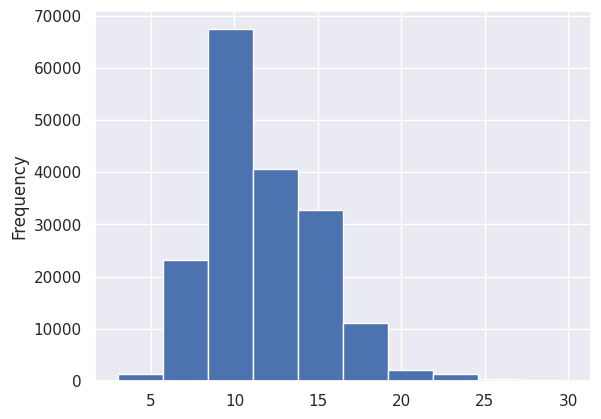

In [16]:
# plot the distribution of length diffrent lines
train_df.total_lines.plot.hist();

As we can see from the chart above we can see many sentences length starts from 6 to 15 and the highest is 10 senteces.

## Get List of Sentences

Because we only work with text data, so we just only take the text from DataFrame.

Instead of work with series, we change it into list (the common input type in deep learning).

In [17]:
# convert abstract text lines into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30212)

In [18]:
# get the sample of the text
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Convert The Labels into Numerical

In [19]:
one_hot_encoder = OneHotEncoder(sparse=False) # non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

# how the data looks like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label Encode Labels

In [20]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# how the data looks like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# get class names
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model Experiments

## Model 0: Getting The Baseline

The first model we use is Naive Bayes Classifier. The purpose of making a baseline is to see the performance of very basic model and our target is to beat the the performance of the baseline.


In [22]:
# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# fit the train data to the pipeline
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# evaluate the baseline model
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Looks like 72% is the score that has to be beaten for deep learning models.

In [24]:
# make prediction using baseline model
predict_result = model_0.predict(X=test_sentences)
predict_result

array([4, 1, 3, ..., 4, 4, 1])

To see our model's performance, use
* `precision`
* `accuracy`
* `recall`
* `f1-score`.

In [25]:
# function to evaluate a model
def calculate_result(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall, and f1 score of a binary classification model.
  Args:
    y_true: the target class of test dataset.
    y_pred: prediction result of model.

  Result:
    Returns a dictionary that filled by accuracy, precision, recall, f1-score.
  """
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {"accuracy":model_accuracy,
                   "precision":precision,
                   "recall":recall,
                   "f1-score":fscore}
  return model_results

In [26]:
baseline_results = calculate_result(test_labels_encoded, predict_result)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1-score': 0.6989250353450294}

## Preparing The Data for Deep Sequence Model

Before making deep learning model, we need to vectorize the text and embedding the text. Vectorize is to make our text into vector and embedding is to make the vectors has relationships.

In [27]:
# how long is each senetence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

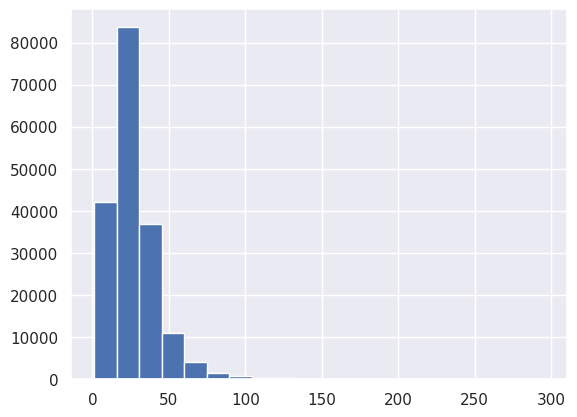

In [28]:
# distribution of sentence length
plt.hist(sent_lens, bins=20);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

In [29]:
# how long of a sentence cover 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

It looks like 95% of the sentences on the training set have a length of 55 tokens or less.

In [30]:
# maximum length in training set
max(sent_lens)

296

### Create Text Vectorize

Section 3.2 of the [PubMed 200k RCT paper](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So use that as `max_tokens`.

In [31]:
# how many words are in the vocabulary?
max_tokens = 68000

In [32]:
# create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=55)

In [33]:
# adapt text_vectorizer to training dataset
text_vectorizer.adapt(train_sentences)

In [34]:
# test out text vectorizer on random sentence
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
The aim of this study was to test the effect different unstable footwear constructions have on centre of pressure motion when standing .

Length of text: 23

Vectorized text: [[    2   267     4    23    17    10     6   128     2    70   197  4176
   8455 40079    99    18  1695     4   200  1322   183  2765     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# how many words in the training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create Custom Text Embedding

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

In [36]:
# create an embedding token layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # use masking to handle variable sequence length
                               mask_zero=True,
                               name="token_embedding")

# show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after vectorization (after embedding):\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
The aim of this study was to test the effect different unstable footwear constructions have on centre of pressure motion when standing .

Sentence after vectorization (before embedding):
[[    2   267     4    23    17    10     6   128     2    70   197  4176
   8455 40079    99    18  1695     4   200  1322   183  2765     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after vectorization (after embedding):
[[[-0.00504346  0.01635805  0.00193864 ... -0.03528241 -0.02723564
    0.0203817 ]
  [ 0.04086791 -0.02494946  0.00149623 ...  0.0347339  -0.04160099
   -0.01767856]
  [ 0.00685161  0.03013866  0.02532312 ... -0.00338223 -0.03527877
    0.00346697]
  ...
  [ 0.02720917 -0.00914522 -0.01701423 ... -0.00245376  0.00087612
    0.03022468]
  [ 0.02720917 -0.00914522 -0.01701423 ... -0.0024537

### Create Datasets (Make the model works faster as fast as possible)

In [37]:
# turn the data into TensorFlow datasets
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_datasets = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_datasets

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# take the TensorSliceDataset's and turn them into prefetched bathces
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
val_datasets = val_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

train_datasets

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with Token Embeddings

All of the deep learning models will follow similar structure:
```
Input(text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The first model is a 1-dimensional Convolutional Neural Network.

In [39]:
# create 1D convlutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
# get the summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [41]:
# Fit the model
model_1_history = model_1.fit(train_datasets,
                              steps_per_epoch=int(0.1 * len(train_datasets)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_datasets,
                              validation_steps=int(0.1 * len(val_datasets)))

Epoch 1/3
562/562 [==============================] - 20s 30ms/step - loss: 0.9022 - accuracy: 0.6452 - val_loss: 0.6843 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6603 - accuracy: 0.7524 - val_loss: 0.6363 - val_accuracy: 0.7650
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6231 - accuracy: 0.7714 - val_loss: 0.6016 - val_accuracy: 0.7829


In [42]:
# evaluate model
model_1.evaluate(val_datasets)

945/945 [==============================] - 4s 4ms/step - loss: 0.6053 - accuracy: 0.7828


[0.6053057312965393, 0.7827684283256531]

In [43]:
model_1_pred_probs = model_1.predict(val_datasets)
model_1_pred_probs

945/945 [==============================] - 4s 5ms/step


array([[4.1333690e-01, 1.6251004e-01, 9.6334316e-02, 3.0113992e-01,
        2.6678784e-02],
       [5.0081861e-01, 2.3047951e-01, 1.3576044e-02, 2.4871074e-01,
        6.4150621e-03],
       [1.3760293e-01, 7.7659246e-03, 1.3598494e-03, 8.5324872e-01,
        2.2626718e-05],
       ...,
       [3.0011870e-06, 6.3206424e-04, 7.7048235e-04, 3.5856324e-06,
        9.9859089e-01],
       [5.4822184e-02, 4.7136077e-01, 9.2400052e-02, 6.3633859e-02,
        3.1778309e-01],
       [1.7036024e-01, 6.6582376e-01, 3.4688465e-02, 4.5431178e-02,
        8.3696350e-02]], dtype=float32)

In [44]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [45]:
# Calculate model_1 results
model_1_results = calculate_result(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.27684363828942,
 'precision': 0.7792413297548639,
 'recall': 0.7827684363828942,
 'f1-score': 0.7801572274707289}

## Model 2: Feature Extraction with Pretrained Tokens Embeddings

Training the own embeddings took a little while to run, slowing our experiments down.

The model is used [pretrained GloVe embeddings](https://nlp.stanford.edu/projects/glove/) as a way to initialise their tokens embeddings.

To emulate this, see what result we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/tensorFlow2/variations/universal-sentence-encoder/versions/2?tfhub-redirect=true)

The model's structure will look like this:


```
Inputs (string) -> pretrained embeddings from TensorFlow Hub(universal sentence encoder) -> Layers -> Outputs (predection probabilities)
```

No tokenization layers is used, because the Universal Sentence Encoder (USE) takes care of tokenization for us.





In [46]:
# download pretrained TensorFlow Hub USE
tf_hub_embeddings_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                         trainable=False,
                                         name="universal_sentence_encoder")

In [47]:
# test the embedding on the sample sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embeddings_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}...\n")
print(f"Length of the sentence:{len(use_embedded_sentence[0])}")

Random training sentence:
Fractional calcium absorption was measured using a triple stable calcium isotope method based on isotope recovery in a @-h urine collection .

Sentence after embedding:
[-0.05090073  0.01693151 -0.03573484  0.02468566  0.02082986 -0.03147326
  0.00796129  0.03174581 -0.02764893  0.0653179   0.03826312  0.03078675
 -0.05228424  0.05394104 -0.0744051  -0.07160472 -0.07501446  0.07583871
 -0.0739599  -0.00348486 -0.07354364 -0.02713005 -0.01602495  0.05388352
  0.0690015   0.00878801  0.01784324 -0.02958268 -0.00689279  0.05234315]...

Length of the sentence:512


The pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a 512 dimensional embedding vector.

### Building and Fitting an NLP Feature Extraction Model

In [48]:
# define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_layer = tf_hub_embeddings_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_layer)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# get a model summary
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [50]:
# fit the feature extraction model
model_2.fit(train_datasets,
            steps_per_epoch=int(0.1*len(train_datasets)),
            epochs=3,
            validation_data=val_datasets,
            validation_steps=int(0.1*len(val_datasets)))

Epoch 1/3
562/562 [==============================] - 10s 12ms/step - loss: 0.9191 - accuracy: 0.6486 - val_loss: 0.7951 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7686 - accuracy: 0.7023 - val_loss: 0.7538 - val_accuracy: 0.7008
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7510 - accuracy: 0.7118 - val_loss: 0.7385 - val_accuracy: 0.7148


In [51]:
# evaluate the model
model_2.evaluate(val_datasets)

945/945 [==============================] - 15s 16ms/step - loss: 0.7407 - accuracy: 0.7148


[0.7407492399215698, 0.7148483991622925]

In [52]:
# make prediction with feature extraction model
model_2_pred_probs = model_2.predict(val_datasets)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[0.4173381 , 0.3666853 , 0.001773  , 0.20624854, 0.00795497],
       [0.3198999 , 0.53954154, 0.00281186, 0.13528413, 0.00246261],
       [0.21853791, 0.15239261, 0.01994056, 0.56888   , 0.04024894],
       ...,
       [0.00175195, 0.00656706, 0.058578  , 0.00098034, 0.93212265],
       [0.0035917 , 0.04736147, 0.21167663, 0.00157432, 0.735796  ],
       [0.17008418, 0.25234428, 0.5128776 , 0.00626095, 0.058433  ]],
      dtype=float32)

In [53]:
# convert pred probabilities to prediction class
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [54]:
# see the results of the prediction
model_2_results = calculate_result(val_labels_encoded, model_2_pred)
model_2_results

{'accuracy': 71.48484046074407,
 'precision': 0.7154574848311164,
 'recall': 0.7148484046074407,
 'f1-score': 0.7118189102537644}

## Model 3: Conv1D with Character Embeddings

The [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts]("chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1612.05251.pdf") paper mentions their model uses a hybrid of token and character embeddings.

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. `hello` -> `[h, e, l, l, o]`) where as a token embedding is created on sequences split into tokens.

In [55]:
# make function to split sentence into characters
def split_chars(sentence):
  return " ".join(list(sentence))

# test the function
split_chars(random_training_sentence)

'F r a c t i o n a l   c a l c i u m   a b s o r p t i o n   w a s   m e a s u r e d   u s i n g   a   t r i p l e   s t a b l e   c a l c i u m   i s o t o p e   m e t h o d   b a s e d   o n   i s o t o p e   r e c o v e r y   i n   a   @ - h   u r i n e   c o l l e c t i o n   .'

In [56]:
# make character datasets
train_chars = [split_chars(text) for text in train_sentences]
val_chars = [split_chars(text) for text in val_sentences]
test_chars = [split_chars(text) for text in test_sentences]

train_chars[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [57]:
# what's the average char length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char = np.mean(char_lens)
mean_char

149.3662574983337

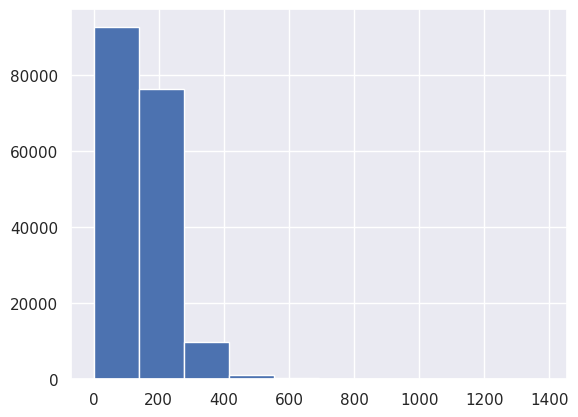

In [58]:
# character distribution
plt.hist(char_lens);

Looks like most of our sequences are between 0 and 200 characters long.

In [59]:
# find what character length cover 95% of a sentence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Set the `max_tokens` into 68. It means alphabet(26) + space + OOV (out of vocabulary) tokens

In [60]:
# get all the characters
import string
alphabet_chars = string.ascii_lowercase + string.digits + string.punctuation
alphabet_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
# create char-level token vectorizer
NUM_TOKENS = len(alphabet_chars) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# adapt to train char
char_vectorizer.adapt(train_chars)

In [62]:
# check character vocabulary characteristics
char_vocabulary = char_vectorizer.get_vocabulary()
print(f"Number of different characters in chapter vocab:: {len(char_vocabulary)}")
print(f"The most 5 characters: {char_vocabulary[:5]}")
print(f"The least 5 characters: {char_vocabulary[-5:]}")

Number of different characters in chapter vocab:: 28
The most 5 characters: ['', '[UNK]', 'e', 't', 'i']
The least 5 characters: ['k', 'x', 'z', 'q', 'j']


In [63]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Characters before vectorization:\n{random_train_chars}\n")
print(f"Length of characters:{len(random_train_chars)}")
vectorization_chars = char_vectorizer([random_train_chars])
print(f"Characters after vectorization:\n{vectorization_chars}\n")
print(f"Length of characters after vectorization:{len(vectorization_chars[0])}")

Characters before vectorization:
P r i o r   t o   t h e   @   m o n t h   p o s t o p e r a t i v e   v i s i t   ,   o n l y   @   %   o f   t r e a t e d   p a r t i c i p a n t s   (   @   o f   @   )   f o r m a l l y   r e p o r t e d   u n m a s k i n g   .

Length of characters:231
Characters after vectorization:
[[14  8  4  7  8  3  7  3 13  2 15  7  6  3 13 14  7  9  3  7 14  2  8  5
   3  4 21  2 21  4  9  4  3  7  6 12 19  7 17  3  8  2  5  3  2 10 14  5
   8  3  4 11  4 14  5  6  3  9  7 17 17  7  8 15  5 12 12 19  8  2 14  7
   8  3  2 10 16  6 15  5  9 23  4  6 18  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 

You'll notice sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

### Creating Character Leve-embedding

In [64]:
# create char embedding layer
char_embed_layer = layers.Embedding(input_dim=NUM_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

# test out the layers
print(f"Characters before embedding:\n{random_train_chars}\n")
char_embedded = char_embed_layer(char_vectorizer([random_train_chars]))
print(f"Characters before embedding:\n{char_embedded}\n")
print(f"Character shape: {char_embedded.shape}")

Characters before embedding:
P r i o r   t o   t h e   @   m o n t h   p o s t o p e r a t i v e   v i s i t   ,   o n l y   @   %   o f   t r e a t e d   p a r t i c i p a n t s   (   @   o f   @   )   f o r m a l l y   r e p o r t e d   u n m a s k i n g   .

Characters before embedding:
[[[-0.01533109 -0.00319858 -0.02337365 ...  0.02303744 -0.0391368
   -0.00180938]
  [ 0.02634775  0.00133938  0.02854731 ...  0.04155869 -0.03734752
    0.02146384]
  [ 0.01595488  0.04221437 -0.03348806 ... -0.04016045  0.0420072
    0.01712391]
  ...
  [-0.00623874  0.00380553  0.00105197 ...  0.01665715  0.01909213
   -0.01787945]
  [-0.00623874  0.00380553  0.00105197 ...  0.01665715  0.01909213
   -0.01787945]
  [-0.00623874  0.00380553  0.00105197 ...  0.01665715  0.01909213
   -0.01787945]]]

Character shape: (1, 290, 25)


### Building a Conv1D Model to Fit on Characters Embedding

In [65]:
# make Conv1D on char only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeds = char_embed_layer(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeds)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_char_embedding")

# compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# get the summary
model_3.summary()

Model: "model_3_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)      

Before fit the model, let's make char dataset and prefecth it.

In [67]:
# make char dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [68]:
# prefetch dataset
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [69]:
# fit the model only chars only
model_3.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=3,
            validation_data=val_char_dataset,
            validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2619 - accuracy: 0.4847 - val_loss: 1.0448 - val_accuracy: 0.5798
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 1.0160 - accuracy: 0.5908 - val_loss: 0.9495 - val_accuracy: 0.6203
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9436 - accuracy: 0.6280 - val_loss: 0.8781 - val_accuracy: 0.6556


In [70]:
# evaluate model_3 on whole validation dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.9026 - accuracy: 0.6511


[0.9026499390602112, 0.651098906993866]

In [71]:
# make prediction probabilities
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.13114607, 0.30099452, 0.19097745, 0.29381442, 0.08306751],
       [0.37670228, 0.36921516, 0.03642603, 0.09878564, 0.11887098],
       [0.13180134, 0.17994942, 0.37902647, 0.2609207 , 0.04830201],
       ...,
       [0.02118006, 0.03124217, 0.15386444, 0.02107834, 0.772635  ],
       [0.03267305, 0.14409305, 0.4462316 , 0.0596338 , 0.3173686 ],
       [0.44543096, 0.40700457, 0.09341663, 0.04553613, 0.00861174]],
      dtype=float32)

In [72]:
# get the class of pred probs
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 2, ..., 4, 2, 0])>

In [73]:
# calculate model Conv1D char only model results
model_3_results = calculate_result(val_labels_encoded, model_3_pred)
model_3_results

{'accuracy': 65.10989010989012,
 'precision': 0.64684699160115,
 'recall': 0.6510989010989011,
 'f1-score': 0.6425189330177262}

## Model 4: Combining Pretrained Tokens Embeddings + Character Embeddings (hybird embeddings)

The hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to 5. Figure 1 and section 4.2 of [Neural Networks for Joint Sentence Classification]("chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1612.05251.pdf")
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [74]:
# setup token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = tf_hub_embeddings_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# setup char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeds = char_embed_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeds)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# concatenate the tokens and chars inputs
token_char_concat = layers.Concatenate(name="token_char_hybird" )([token_model.output,
                                                                   char_model.output])

# create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# construct model with char and tokens input
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_char_embeddings")

In [75]:
# get summary of token and character model
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['

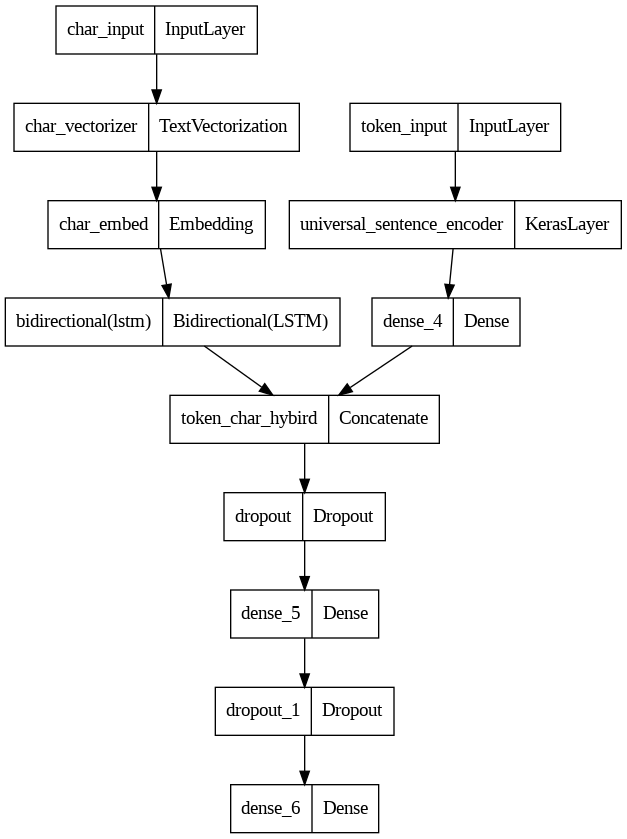

In [76]:
# plot hybird token and char model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [77]:
# compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Before fitting the data to the model, make a dataset that filled with combination between char and token dataset.

After combining those, prefetech and turn that into `32 batches` so our model can train faster.

### Combining Token and Character Data Into a `tf.data` Dataset

In [78]:
# combine char and token into dataset
token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
token_char_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
token_char_dataset = tf.data.Dataset.zip((token_char_data, token_char_label))
# prefetch train dataset
train_token_char_dataset = token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# do the same thing to validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make val data
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
# prefecth val dataset
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [79]:
# check the training and validation dataset
train_token_char_dataset, val_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting The Model on Tokens + Char Dataset

Train the model and using 10% of data for the steps (just to make the training session faster).

In [80]:
# fit the model
model_4_history = model_4.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_token_char_dataset)),
                              epochs=3,
                              validation_data=val_token_char_dataset,
                              validation_steps=int(0.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 60ms/step - loss: 0.9871 - accuracy: 0.6041 - val_loss: 0.7835 - val_accuracy: 0.7001
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.8031 - accuracy: 0.6881 - val_loss: 0.7223 - val_accuracy: 0.7247
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7768 - accuracy: 0.7033 - val_loss: 0.6904 - val_accuracy: 0.7370


In [81]:
# evaluate the model
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.6960 - accuracy: 0.7329


[0.6959600448608398, 0.7328875660896301]

In [82]:
# predict validation dataset
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 23ms/step


array([[4.0374428e-01, 4.1855085e-01, 2.8353184e-03, 1.6979706e-01,
        5.0725061e-03],
       [3.1043392e-01, 5.0920600e-01, 3.8903041e-03, 1.7361641e-01,
        2.8533866e-03],
       [3.0745682e-01, 1.7005257e-01, 6.1131820e-02, 4.2776200e-01,
        3.3596788e-02],
       ...,
       [3.5284893e-04, 7.9102702e-03, 3.9348453e-02, 1.2442589e-04,
        9.5226401e-01],
       [7.7181235e-03, 7.3865622e-02, 2.7979827e-01, 3.6697548e-03,
        6.3494819e-01],
       [1.8464974e-01, 2.7638578e-01, 4.7745791e-01, 1.3613320e-02,
        4.7893193e-02]], dtype=float32)

In [83]:
# get the class of the prediction probs
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [84]:
# get results of model hybird token and chars
model_4_results = calculate_result(val_labels_encoded, model_4_pred)
model_4_results

{'accuracy': 73.28875943333775,
 'precision': 0.7345208763645521,
 'recall': 0.7328875943333775,
 'f1-score': 0.7294959191605175}

## Model 5: Transfer Learning with Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

For this model, we are going to apply what we know about the data and encoded it in a numerical way to give a model more information about the samples.

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

So now, we encode the order of a set of sequence in an abstract.

For example,

* `Sentence 1 of 10 ...`
* `Sentence 2 of 10 ...`
* `Sentence 3 of 10 ...`
* `Sentence 4 of 10 ...`

In [85]:
# inspect the train data
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

### Create Positional Embeddings

Since `line_number` and `total_lines` are already in there, we can pass those columns to the model.

But to avoid the model thinks that line number 5 is five times greater than line number 1, we can use `one-hot encoder` to encode those columns.

In [86]:
# how many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

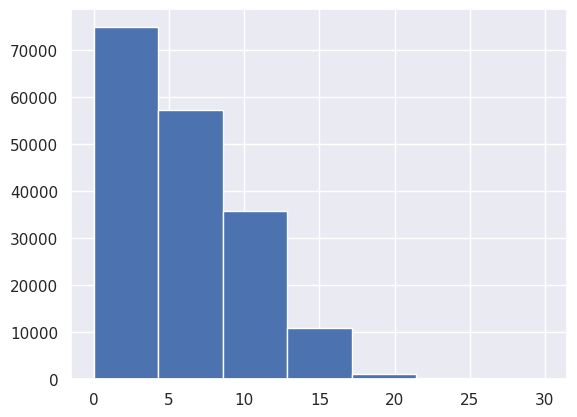

In [87]:
# check the distribution of line_number column
plt.hist(train_df['line_number'], bins=7);

Looks like the majority of lines have 15 or less.

Knowing this, let's set the depth parameter in `tf.one_hot` to 15.

In [88]:
# use TensorFlow to one-hot encode tensors to the line_number of column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [89]:
# check the line_number samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:10]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

We can do the same thing to `total_lines` column.

Let's see the distribution of `total_lines`.

In [90]:
# how many different numbers of lines there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

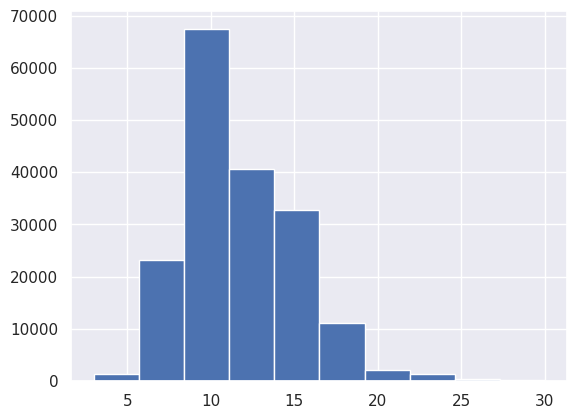

In [91]:
# check the distribution
plt.hist(train_df['total_lines']);

It looks like the majority of `total_lines` is from 5 to 20. We can confirm this with `np.percentile`

In [92]:
# check the coverage of a "total_lines" value of 20
np.percentile(train_df['total_lines'], 98)

20.0

In [93]:
# use TensorFlow to create one-hot encoded to total_line columns
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [94]:
# check the features one-hot encoded sample
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Build a Tribrid Embedding Model

The following steps:
1. Create Token-level model (similar to `model_1`).
2. Create Char-level model (similar to `model_3`).
3. Create a `line_number` model.
4. Creat a `total_line` model.
5. Combine the output of 1 and 2 using `tf.keras.layers.concatenate`.
6. Combine the output of 3, 4, & 5 using `tf.keras.layers.concatenate`.
7. Create an output layer to accept the tribrid embedding and output label probablities.
8. Combine the inputs 1,2,3,4 and outputs of 7 into a `tf.keras.Model`.

In [95]:
# create token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embeddings_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# creat char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# create line_number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# create total_line model
total_line_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_line_inputs")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs, outputs=y)

# combine token and char embedding into a hybird embedding
combined_embeddings = layers.Concatenate(name="token_char_hybird_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# combine positional embedding with token and char embedding into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                               total_line_model.output,
                                                               z])

# create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# combine every models to be one model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [96]:
# get a model summary
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

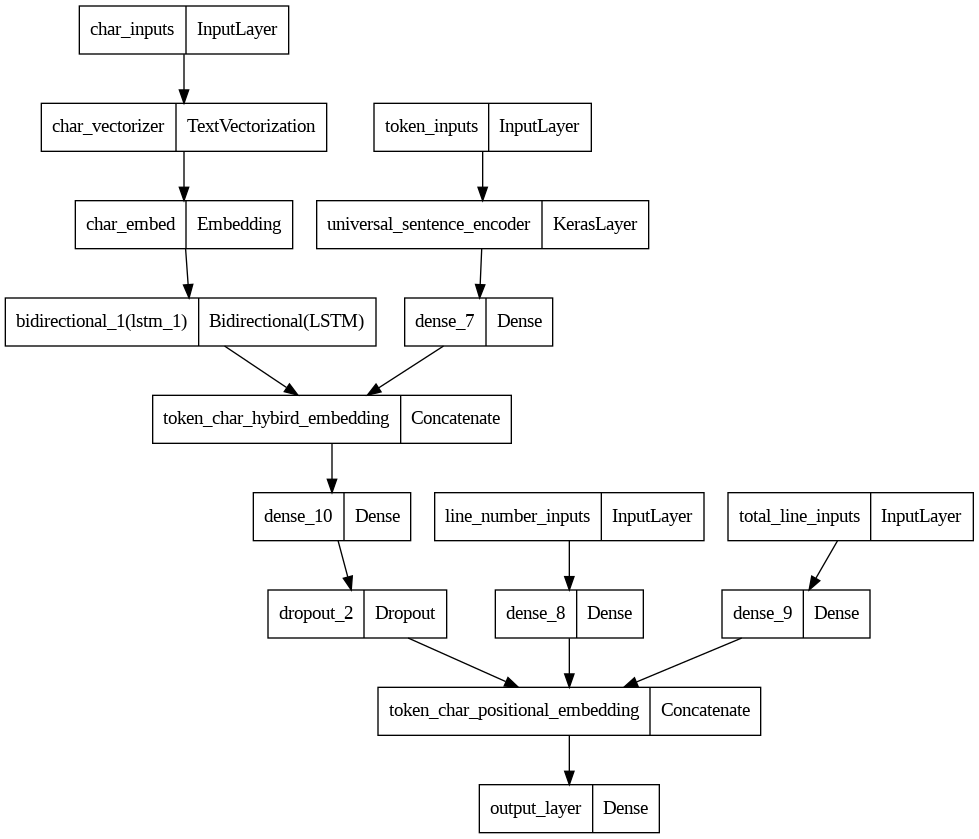

In [97]:
# get the model visualization
plot_model(model_5)

Essentially what we're doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

In [98]:
# check the model layers
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b3339c705b0> True
<keras.src.engine.input_layer.InputLayer object at 0x7b3339c71720> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7b329cd90d30> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7b33b7ee1090> False
<keras.src.layers.core.embedding.Embedding object at 0x7b329cda5360> True
<keras.src.layers.core.dense.Dense object at 0x7b3339c71c60> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7b3339ddcb80> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7b33b8a65f90> True
<keras.src.engine.input_layer.InputLayer object at 0x7b33b808cbe0> True
<keras.src.engine.input_layer.InputLayer object at 0x7b33b804c910> True
<keras.src.layers.core.dense.Dense object at 0x7b33b7ec1900> True
<keras.src.layers.core.dense.Dense object at 0x7b33b7ee6770> True
<keras.src.layers.core.dense.Dense object at 0x7b33b804dd20> True
<keras.src.layers.regularization.dropout.

Model is ready to be compiled.

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

In [99]:
# compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create Tribrid Embeddings Datasets and Fit Tribrid Model

This time our model requires four feature inputs:

1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

In [100]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [101]:
# fit the token, char, and pos embeddings model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 47ms/step - loss: 1.0980 - accuracy: 0.7243 - val_loss: 0.9855 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.9674 - accuracy: 0.8146 - val_loss: 0.9515 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 18s 31ms/step - loss: 0.9508 - accuracy: 0.8241 - val_loss: 0.9426 - val_accuracy: 0.8298


In [102]:
# evaluate using whole validation dataset
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.9392 - accuracy: 0.8310


[0.939201295375824, 0.8309943079948425]

In [103]:
# make predictions probability with the whole val dataset
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 18s 18ms/step


array([[0.51246864, 0.12040856, 0.01166829, 0.33481503, 0.02063951],
       [0.5237027 , 0.12478393, 0.04513394, 0.2967237 , 0.0096558 ],
       [0.28845236, 0.1241269 , 0.11492333, 0.4111134 , 0.06138398],
       ...,
       [0.03513269, 0.11877719, 0.04140271, 0.03207369, 0.7726137 ],
       [0.03185185, 0.3099642 , 0.06904178, 0.02546725, 0.56367487],
       [0.25024858, 0.54659075, 0.09470591, 0.04841883, 0.06003594]],
      dtype=float32)

In [104]:
# take the class target
model_5_pred = tf.argmax(model_5_pred_probs, axis=1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [105]:
# calculate the results
model_5_results = calculate_result(val_labels_encoded, model_5_pred)
model_5_results

{'accuracy': 83.09943068979213,
 'precision': 0.8299773319081301,
 'recall': 0.8309943068979213,
 'f1-score': 0.8302194187108923}

## Compare The Models Results

After making those models, it's time to compare the results to see what the best model to use in predicting test data.

In [106]:
# combine the model's results
all_model_results = pd.DataFrame({"baseline":baseline_results,
                                  "custom_token_embed_conv1D":model_1_results,
                                  "pretrained_token_embed":model_2_results,
                                  "char_embed_conv1D":model_3_results,
                                  "hybrid_token_char_embed":model_4_results,
                                  "tribrid_pos_char_token_embed":model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1-score
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1D,78.276844,0.779241,0.782768,0.780157
pretrained_token_embed,71.484840,0.715457,0.714848,0.711819
char_embed_conv1D,65.109890,0.646847,0.651099,0.642519
hybrid_token_char_embed,73.288759,0.734521,0.732888,0.729496
tribrid_pos_char_token_embed,83.099431,0.829977,0.830994,0.830219


In [107]:
# reduce the accuracy
all_model_results['accuracy'] = all_model_results['accuracy']/100

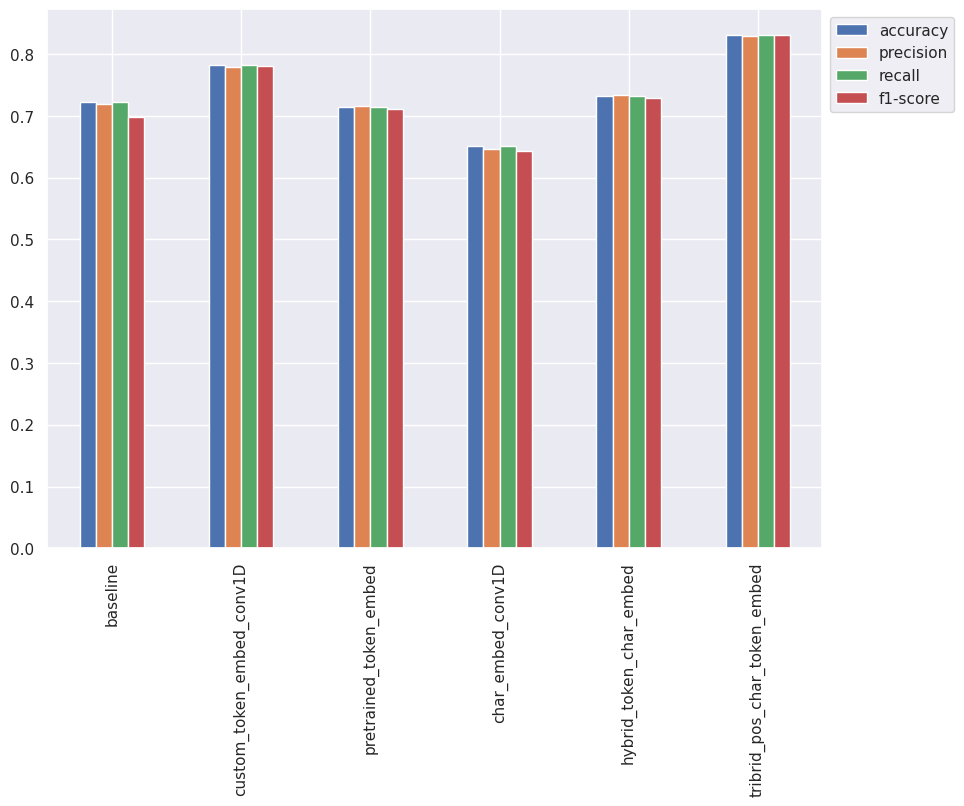

In [108]:
# plot the model results and compare it
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Since the [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts]("chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1710.06071.pdf") paper compares their tested model's F1-scores on the test dataset, let's take at our model's F1-scores.

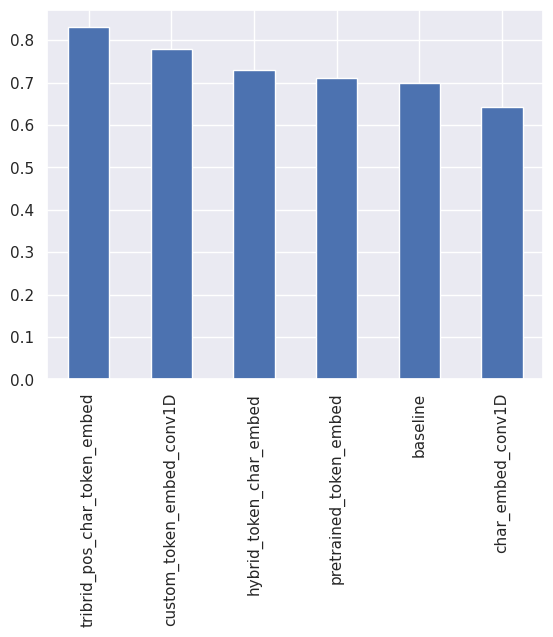

In [109]:
# sort the values of f1-score
all_model_results.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar");

Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

There are some thing note about this difference:
* The models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.
  * This is often the case in machine learning experiments though, make sure training works on a smaller number of samples, then upscale when needed (an extension to this project will be training a model on the full dataset).
* The model's prediction performance levels have been evaluated on the validation dataset not the test dataset.

## Save The Model

Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

In [110]:
# save the best performing model
model_5.save("skimlit_tribrid_model")

## Make Prediction with The Saved Model Againts The Truth Labels

To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.

In [111]:
# load the model
model_path = "/content/skimlit_tribrid_model"
loaded_model = tf.keras.models.load_model(model_path)

In [112]:
# make prediction to see if the performance same or not
loaded_model_pred_probs = loaded_model.predict(val_pos_char_token_dataset)

# get the class of pred probs
loaded_model_pred = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_results = calculate_result(val_labels_encoded, loaded_model_pred)
loaded_model_results

945/945 [==============================] - 18s 18ms/step


{'accuracy': 83.09943068979213,
 'precision': 0.8299773319081301,
 'recall': 0.8309943068979213,
 'f1-score': 0.8302194187108923}

## Evaluate The Model on Test Dataset

In [113]:
# create test dataset batch and prefetch
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# check what the data looks like
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [114]:
# make predictions on test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset, verbose=1)

test_pred = tf.argmax(test_pred_probs, axis=1)
test_pred

945/945 [==============================] - 16s 17ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [115]:
# evaluate loaded model predictions
test_model_results = calculate_result(test_labels_encoded, test_pred)
test_model_results

{'accuracy': 83.09943068979213,
 'precision': 0.8299773319081301,
 'recall': 0.8309943068979213,
 'f1-score': 0.8302194187108923}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper.

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

## Find The Most Wrong

One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

In [116]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_pred]
test_pred_classes[:10]

CPU times: user 14 s, sys: 850 ms, total: 14.8 s
Wall time: 14.4 s


['BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS']

Now we'll enrich our test DataFame with a few values:

* A `"prediction"` (string) column containing our model's prediction for a given sample.
* A `"pred_prob"` (float) column containing the model's maximum prediction probabiliy for a given sample.
* A `"correct"` (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [117]:
# create prediction enrich test dataframe
test_df['prediction'] = test_pred_classes
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df['correct'] = test_df['prediction'] == test_df['target']
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9,BACKGROUND,0.512469,True
1,BACKGROUND,It is not clear whether these patients would b...,1,9,BACKGROUND,0.523703,True
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9,OBJECTIVE,0.411113,True
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9,METHODS,0.719879,True
4,METHODS,Primary outcomes were improvement in quality o...,4,9,METHODS,0.681482,True
5,RESULTS,Sixty-five patients were randomized .,5,9,RESULTS,0.637200,True
6,RESULTS,Fifty-nine patients started treatment ( @ rece...,6,9,RESULTS,0.712555,True
7,RESULTS,Fifty-six patients took the full @ months of m...,7,9,RESULTS,0.720947,True
8,RESULTS,"Between the voriconazole and placebo groups , ...",8,9,RESULTS,0.876216,True
9,CONCLUSIONS,We were unable to show a beneficial effect of ...,9,9,CONCLUSIONS,0.730360,True


In [118]:
# find top 100 most wrong samples
top_100_wrong = test_df[test_df['correct']==False].sort_values('pred_prob')[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
15361,RESULTS,"However , physicians tended to switch to more ...",3,4,BACKGROUND,0.223522,False
1604,OBJECTIVE,There are no enough studies and research on th...,6,15,METHODS,0.243161,False
29076,BACKGROUND,The goal of this trial was to evaluate the eff...,5,16,OBJECTIVE,0.243704,False
17184,RESULTS,These factors evidenced good internal consiste...,3,8,BACKGROUND,0.247332,False
10791,METHODS,The intervention emphasized moderate caloric r...,5,14,CONCLUSIONS,0.248386,False
...,...,...,...,...,...,...,...
1062,BACKGROUND,"Therefore , we investigated the BMI-related co...",4,12,METHODS,0.301667,False
6964,METHODS,"After randomization , both formats used a web-...",6,19,RESULTS,0.301878,False
4144,BACKGROUND,Ethics review committees at the Keio Universit...,8,11,METHODS,0.301932,False
25475,BACKGROUND,This trial aims to assess the efficacy and cos...,4,12,OBJECTIVE,0.302169,False


In [119]:
# investigate top wrong preds
for row in top_100_wrong[:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Prediction: {prediction}, Probabilities: {pred_prob}, Line Number: {line_number}, Total Lines: {total_lines}\n")
  print(f"Text: \n{text}\n")
  print("----------\n")

Target: RESULTS, Prediction: BACKGROUND, Probabilities: 0.22352205216884613, Line Number: 3, Total Lines: 4

Text: 
However , physicians tended to switch to more intensive therapy for DM in the atorvastatin group .

----------

Target: OBJECTIVE, Prediction: METHODS, Probabilities: 0.2431606948375702, Line Number: 6, Total Lines: 15

Text: 
There are no enough studies and research on the effect of vitamin B@ on the symptoms of PMS , therefore , this study was conducted to determine the effect of vitamin B@ on the symptoms of PMS in students residing at dormitories of Jahrom University of Medical Sciences in @ .

----------

Target: BACKGROUND, Prediction: OBJECTIVE, Probabilities: 0.24370402097702026, Line Number: 5, Total Lines: 16

Text: 
The goal of this trial was to evaluate the efficacy of TSU-@ in combination with SOX .

----------

Target: RESULTS, Prediction: BACKGROUND, Probabilities: 0.2473323494195938, Line Number: 3, Total Lines: 8

Text: 
These factors evidenced good inter

## Make Sample Prediction

The following unstructured abstract from [RCT of a manualized social treatment for high-functioning autism spectrum disorders]("https://pubmed.ncbi.nlm.nih.gov/20232240/"):

> This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Looking at the large chunk of text can seem quite intimidating. Now imagine you're a medical researcher trying to skim through the literature to find a study relevant to your work.

As you might've guessed the above abstract hasn't been formatted in the same structure as the data our model has been trained on. Therefore, before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we'll need to:

1. Split it into sentences (lines).
2. Split it into characters.
3. Find the number of each line.
4. Find the total number of lines.



In [121]:
import json
# download and open example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstract = json.load(f)

example_abstract

--2024-01-16 00:56:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-01-16 00:56:07 (83.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [122]:
# what abstract example looks like
abstract = pd.DataFrame(example_abstract)
abstract

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


Before test this into the model, first we need to parse it using `spaCy` to turn it from big chunk of text into sentences.

In [125]:
# create sentencizer
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.add_pipe("sentencizer")

# create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstract[0]["abstract"])
abstract_lines = [str(lines) for lines in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

Now the abstract has been split into sentences, how about we write some code to count line numbers as well as total lines.

In [131]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict['text'] = str(line)
  sample_dict['line_number'] = i
  sample_dict['total_line'] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_line': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_line': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_line': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_line': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_line': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_line': 7},
 {'text': 'Hig

In [132]:
# get all line numbers value from sample abstract
abstract_line_number = [line["line_number"] for line in sample_lines]
# one-hot encode to same depth as trainig data, so model accepts the right input
test_abstract_line_number_one_hot = tf.one_hot(abstract_line_number, depth=15)
test_abstract_line_number_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [133]:
# get all total line value from sample abstract
abstract_total_line = [line["total_line"] for line in sample_lines]
# one-hot encode to same depth as training data
test_abstract_total_line_one_hot = tf.one_hot(abstract_total_line, depth=20)
test_abstract_total_line_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [134]:
# split the sentences into chars
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [138]:
# make a prediction on sample dataset
%%time
test_abstract_pred_probs = loaded_model.predict((test_abstract_line_number_one_hot,
                                                 test_abstract_total_line_one_hot,
                                                 tf.constant(abstract_lines),
                                                 tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step
CPU times: user 1.64 s, sys: 12.5 ms, total: 1.65 s
Wall time: 2.45 s


array([[0.28991866, 0.11405388, 0.01452124, 0.550006  , 0.03150024],
       [0.07873968, 0.03064219, 0.69224477, 0.11175183, 0.08662158],
       [0.12034509, 0.03787164, 0.5538382 , 0.18554126, 0.10240392],
       [0.11099503, 0.15449107, 0.4897103 , 0.0894247 , 0.1553789 ],
       [0.05189442, 0.08698711, 0.42604822, 0.04734456, 0.38772568],
       [0.03662981, 0.0966404 , 0.607757  , 0.04216718, 0.21680562],
       [0.0311265 , 0.13603598, 0.07178353, 0.02522124, 0.73583275],
       [0.01704575, 0.10975743, 0.2367276 , 0.0279795 , 0.60848975]],
      dtype=float32)

In [139]:
# get the class prediction
test_pred = tf.argmax(test_abstract_pred_probs, axis=1)
test_pred

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [140]:
# turn the number of classes into class string name
test_class = [label_encoder.classes_[i] for i in test_pred]
test_class

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [144]:
# visualize the prediction result
for i, line in enumerate(abstract_lines):
  print(f"{test_class[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


Now the abstract is easier to read!

Imagine implementing our model to the backend of the PubMed website to format any unstructured RCT abstract on the site.

Or there could even be a browser extension, called "SkimLit" which would add structure (powered by our model) to any unstructured RCT abtract. 🤖